In [135]:
import pandas as pd
import numpy as np
import requests
import urllib
import psycopg2
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize.rdMolStandardize import FragmentParent

login = yaml.safe_load(open('db_conn_login.yaml'))['CHEMBL']

In [91]:
# From https://www.uniprot.org/help/api_queries
# Tutorial from https://iwatobipen.wordpress.com/2022/04/08/make-curated-kinase-inhibitor-dataset-from-chembl30-memo-chemoinformatcs/

target_gene_list = ['JAK2', 'LCK',
                   'PPARA', 'PPARD', 'PPARG',
                   'CYP3A4',
                   'hERG',]

gene_df_all_targets = None

counter = 0
for gene in target_gene_list:
    counter += 1
    
    url = "https://rest.uniprot.org/uniprotkb/search?query=reviewed:true+AND+gene_exact:{0}&format=tsv".format(gene)
    gene_data = [i.split('\t') for i in requests.get(url).text.split('\n')]
    gene_data_cleaned = []
    [gene_data_cleaned.append(i) if len(i)>1 else None for i in gene_data]
    
    gene_df = pd.DataFrame(gene_data_cleaned[1:], columns=gene_data_cleaned[0])
    gene_df['Gene ID'] = [gene]*len(gene_df)
    
    if counter == 1:
        gene_df_all_targets = pd.DataFrame(columns=gene_df.columns)
        
    gene_df_all_targets = pd.concat([gene_df_all_targets, gene_df], axis=0)
    
CHEMBL_VERSION = 35
url = fr"ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_{CHEMBL_VERSION}/chembl_uniprot_mapping.txt"
with urllib.request.urlopen(url) as response:
    uniprot_map = pd.read_csv(response, sep="\t", skiprows=[0], names=["UniprotID", "chembl_targets", "description", "type"])
    
# Only keep single protein targets
uniprot_chembl_targets = uniprot_map[(uniprot_map['UniprotID'].isin(gene_df_all_targets['Entry'].tolist())) & (uniprot_map['type'] == 'SINGLE PROTEIN')]
uniprot_gene_chembl_targets = pd.merge(uniprot_chembl_targets, gene_df_all_targets[['Entry','Gene ID']], how='left', left_on='UniprotID', right_on='Entry')


In [92]:
# ChEMBL schema - https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_schema.png
connection = psycopg2.connect(user=login['username'], password=login['password'], host=login['host'], port=login['port'], database=login['database'])

targets = set(uniprot_gene_chembl_targets.chembl_targets.tolist())

# Only pull back IC50 and EC50 data part of binding assays
query = f"""
SELECT assay_type.assay_type, assay_type.assay_desc, assays.assay_id, target_dictionary.chembl_id, molecule_dictionary.chembl_id as moldict_id, activities.text_value, activities.molregno, activities.relation, activities.type, activities.value, activities.units, activities.standard_relation, 
activities.activity_id, activities.standard_type, activities.standard_value, activities.standard_units, activities.activity_comment, activities.data_validity_comment, assays.assay_organism, assays.assay_strain, assays.assay_tissue, assays.assay_cell_type,
molecule_dictionary.max_phase, compound_structures.canonical_smiles, compound_structures.standard_inchi, component_sequences.sequence, docs.year, docs.authors, docs.chembl_id as docs_id,
target_dictionary.target_type, target_dictionary.pref_name, target_dictionary.organism
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN assay_type ON assay_type.assay_type=assays.assay_type
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN molecule_dictionary ON activities.molregno=molecule_dictionary.molregno
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
WHERE
    target_dictionary.chembl_id IN {tuple(targets)}
AND
    activities.standard_relation='='
AND
    assays.assay_type='B'
AND
    activities.standard_type in ('IC50', 'EC50')
AND
    assays.confidence_score > 0
AND
    activities.standard_units='nM'
"""

chembl_dataset = pd.read_sql_query(query, con=connection)
connection.close()

chembl_name_to_gene = {"Tyrosine-protein kinase JAK2": "JAK2",
                      "Tyrosine-protein kinase LCK": "LCK",
                      "Peroxisome proliferator-activated receptor alpha": "PPARa",
                      "Peroxisome proliferator-activated receptor delta": "PPARd",
                      "Peroxisome proliferator-activated receptor gamma": "PPARg",
                      "HERG": "hERG",
                      "Cytochrome P450 3A4": "CYP3A4"}

chembl_dataset["Target"] = chembl_dataset['pref_name'].map(chembl_name_to_gene) 

chembl_dataset.head()


,assay_type,assay_desc,assay_id,chembl_id,moldict_id,text_value,molregno,relation,type,value,...,canonical_smiles,standard_inchi,sequence,year,authors,docs_id,target_type,pref_name,organism,Target
0,B,Binding,70495,CHEMBL258,CHEMBL90976,None,148362,=,IC50,0.081,...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,InChI=1S/C41H50N5O21P/c1-3-20(2)36(40(59)44-28...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,2002.0,"Park SH, Won J, Lee KH.",CHEMBL1135345,SINGLE PROTEIN,Tyrosine-protein kinase LCK,Homo sapiens,LCK
1,B,Binding,67205,CHEMBL258,CHEMBL169780,None,282629,=,IC50,0.360,...,Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCN(CCO)CC1,InChI=1S/C19H23N5O2/c20-18-17-16(13-2-1-3-15(2...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,2001.0,"Altmann E, Missbach M, Green J, Susa M, Wagenk...",CHEMBL1134003,SINGLE PROTEIN,Tyrosine-protein kinase LCK,Homo sapiens,LCK
2,B,Binding,67205,CHEMBL258,CHEMBL262276,None,282139,=,IC50,0.290,...,COC(=O)CN1CCC(n2cc(-c3cccc(O)c3)c3c(N)ncnc32)CC1,InChI=1S/C20H23N5O3/c1-28-17(27)11-24-7-5-14(6...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,2001.0,"Altmann E, Missbach M, Green J, Susa M, Wagenk...",CHEMBL1134003,SINGLE PROTEIN,Tyrosine-protein kinase LCK,Homo sapiens,LCK
3,B,Binding,67205,CHEMBL258,CHEMBL169920,None,282595,=,IC50,0.400,...,CN(C)C(=O)CN1CCC(n2cc(-c3cccc(O)c3)c3c(N)ncnc3...,InChI=1S/C21H26N6O2/c1-25(2)18(29)12-26-8-6-15...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,2001.0,"Altmann E, Missbach M, Green J, Susa M, Wagenk...",CHEMBL1134003,SINGLE PROTEIN,Tyrosine-protein kinase LCK,Homo sapiens,LCK
4,B,Binding,67205,CHEMBL258,CHEMBL168661,None,282244,=,IC50,0.340,...,COc1cccc(-c2cn(C3CCN(CCN(C)CCO)CC3)c3ncnc(N)c2...,InChI=1S/C23H32N6O2/c1-27(12-13-30)10-11-28-8-...,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,2001.0,"Altmann E, Missbach M, Green J, Susa M, Wagenk...",CHEMBL1134003,SINGLE PROTEIN,Tyrosine-protein kinase LCK,Homo sapiens,LCK


In [93]:
connection = psycopg2.connect(user=login['username'], password=login['password'], host=login['host'], port=login['port'], database=login['database'])
test = pd.read_sql_query("SELECT distinct assays.description from assays", con=connection)
connection.close()

In [94]:
test_filter = [i for i in test["description"].tolist() if i != None]

In [182]:
cad_desc = [i for i in test_filter if "solubility" in i.lower() and "cad" in i.lower()]

print(cad_desc)

['Aqueous solubility in PBS at pH 7.4 by CAD analysis', 'Kinetic aqueous solubility of the compound by CAD or CLND method', 'Kinetic solubility of compound in DMSO using the charged aerosol detector (CAD) analysis', 'Solubility of the compound by CAD method']


In [183]:
# Pull back CAD solubility data
connection = psycopg2.connect(user=login['username'], password=login['password'], host=login['host'], port=login['port'], database=login['database'])

# Only pull back physicochemical assays
query = f"""
SELECT assays.description, assay_type.assay_type, assay_type.assay_desc, assays.assay_id, target_dictionary.chembl_id, molecule_dictionary.chembl_id as moldict_id, activities.text_value, activities.molregno, activities.relation, activities.type, activities.value, activities.units, activities.standard_relation, 
activities.activity_id, activities.standard_type, activities.standard_value, activities.standard_units, activities.activity_comment, activities.data_validity_comment, assays.assay_organism, assays.assay_strain, assays.assay_tissue, assays.assay_cell_type,
molecule_dictionary.max_phase, compound_structures.canonical_smiles, compound_structures.standard_inchi, component_sequences.sequence, docs.year, docs.authors, docs.chembl_id as docs_id
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN assay_type ON assay_type.assay_type=assays.assay_type
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN molecule_dictionary ON activities.molregno=molecule_dictionary.molregno
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
WHERE
    assays.description IN {tuple(cad_desc)}
AND
    assays.assay_type='P'
AND
    activities.standard_relation='='
"""

CAD_dataset = pd.read_sql_query(query, con=connection)
connection.close()

CAD_dataset["Target"] = "CAD solubility"
CAD_dataset.head()


,description,assay_type,assay_desc,assay_id,chembl_id,moldict_id,text_value,molregno,relation,type,...,assay_tissue,assay_cell_type,max_phase,canonical_smiles,standard_inchi,sequence,year,authors,docs_id,Target
0,Aqueous solubility in PBS at pH 7.4 by CAD ana...,P,Physicochemical,2334894,CHEMBL2362975,CHEMBL5436853,None,2877021,=,solubility,...,None,None,NaN,CCOC(=O)c1ccc(-c2ccc3c(c2)[C@@H](Nc2ccc4ccsc4c...,InChI=1S/C29H28N2O3S/c1-4-34-29(33)22-7-5-20(6...,None,2023,"Schiedel M, McArdle DJB, Padalino G, Chan AKN,...",CHEMBL5344427,CAD solubility
1,Aqueous solubility in PBS at pH 7.4 by CAD ana...,P,Physicochemical,2334894,CHEMBL2362975,CHEMBL5425680,None,2865848,=,solubility,...,None,None,NaN,CCOC(=O)c1ccc(-c2ccc3c(c2)[C@H](Nc2ccc4ncccc4c...,InChI=1S/C30H29N3O3/c1-4-36-30(35)22-9-7-21(8-...,None,2023,"Schiedel M, McArdle DJB, Padalino G, Chan AKN,...",CHEMBL5344427,CAD solubility
2,Kinetic aqueous solubility of the compound by ...,P,Physicochemical,1788744,CHEMBL2362975,CHEMBL4287894,None,2327342,=,Kinetic_solubility,...,None,None,NaN,O=C(N[C@@H](CO)c1cccc(Cl)c1)[C@H]1CC(F)(F)CC[C...,InChI=1S/C21H22ClF2NO2/c22-16-8-4-7-15(11-16)1...,None,2018,"Seefeld MA, Lin H, Holenz J, Downie D, Donovan...",CHEMBL4257569,CAD solubility
3,Kinetic aqueous solubility of the compound by ...,P,Physicochemical,1788744,CHEMBL2362975,CHEMBL4276984,None,2316435,=,Kinetic_solubility,...,None,None,NaN,C[C@H](NC(=O)c1cc(C(F)(F)F)ccc1Oc1ccccc1)c1ccc...,InChI=1S/C23H20F3NO4S/c1-15(16-7-6-10-19(13-16...,None,2018,"Seefeld MA, Lin H, Holenz J, Downie D, Donovan...",CHEMBL4257569,CAD solubility
4,Kinetic aqueous solubility of the compound by ...,P,Physicochemical,1788744,CHEMBL2362975,CHEMBL4287234,None,2326682,=,Kinetic_solubility,...,None,None,NaN,CS(=O)(=O)c1cccc(CNC(=O)c2cc(C(F)(F)F)ccc2Sc2c...,"InChI=1S/C22H18F3NO3S2/c1-31(28,29)18-9-5-6-15...",None,2018,"Seefeld MA, Lin H, Holenz J, Downie D, Donovan...",CHEMBL4257569,CAD solubility


In [184]:
CAD_dataset["standard_units"].unique()

array(['nM', 'ug.mL-1'], dtype=object)

In [186]:
# Convert nM to ug/mL
CAD_vals = []

for idx, row in CAD_dataset.iterrows():
    if row["standard_units"] == "nM":
        mol = Chem.MolFromSmiles(row["canonical_smiles"])
        microM = row["standard_value"] / 1000 # convert nM to uM
        CAD_vals.append((Descriptors.ExactMolWt(mol)/1000) * microM)
    else:
        CAD_vals.append(row["standard_value"])

CAD_dataset["ug/mL"] = CAD_vals


In [187]:
len(CAD_dataset)

40

In [188]:
# CAD is quite small - can use CLND instead
clnd_desc = [i for i in test_filter if "solubility" in i.lower() and "clnd" in i.lower() and "7.4" in i.lower()]

print(clnd_desc)

# Pull back CAD solubility data
connection = psycopg2.connect(user=login['username'], password=login['password'], host=login['host'], port=login['port'], database=login['database'])

# Only pull back physicochemical assays
query = f"""
SELECT assays.description, assay_type.assay_type, assay_type.assay_desc, assays.assay_id, target_dictionary.chembl_id, molecule_dictionary.chembl_id as moldict_id, activities.text_value, activities.molregno, activities.relation, activities.type, activities.value, activities.units, activities.standard_relation, 
activities.activity_id, activities.standard_type, activities.standard_value, activities.standard_units, activities.activity_comment, activities.data_validity_comment, assays.assay_organism, assays.assay_strain, assays.assay_tissue, assays.assay_cell_type,
molecule_dictionary.max_phase, compound_structures.canonical_smiles, compound_structures.standard_inchi, component_sequences.sequence, docs.year, docs.authors, docs.chembl_id as docs_id
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN assay_type ON assay_type.assay_type=assays.assay_type
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN molecule_dictionary ON activities.molregno=molecule_dictionary.molregno
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
WHERE
    assays.description IN {tuple(clnd_desc)}
AND
    assays.assay_type='P'
AND
    activities.standard_relation='='
"""

CLND_dataset = pd.read_sql_query(query, con=connection)
connection.close()

CLND_dataset["Target"] = "CLND solubility"
CLND_dataset.head()


['Aqueous solubility of compound in DMSO/ PBS at pH 7.4 at 200 microM incubated for 24 hrs by shake flask method based chemiluminscent nitrogen detection (CLND) method', 'Kinetic aqueous solubility of the compound at pH 7.4 phosphate buffered saline after 1 hr by CLND method', 'Thermodynamic aqueous solubility of the compound in pH 7.4 phosphate buffer at 2.9 mg/ml after overnight incubation by CLND method', 'Kinetic aqueous solubility of the compound in phosphate buffer at pH 7.4 by CLND assay', 'Solubility of the compound in phosphate buffered saline at pH 7.4 after 1 hr by CLND method', 'Kinetic solubility in pH 7.4 PBS buffer at 100 uM incubated for 24 hrs by LC/CLND method', 'Kinetic solubility of the compound at pH 7.4 by CLND method', 'Kinetic solubility of the compound at pH 7.4 after 1 hr by CLND-based assay', 'Kinetic solubility of compound at pH 7.4 incubated for 24 hrs by LC/CLND method', 'Kinetic aqueous solubility of compound in phosphate buffer at pH 7.4 incubated for 1 

,description,assay_type,assay_desc,assay_id,chembl_id,moldict_id,text_value,molregno,relation,type,...,assay_tissue,assay_cell_type,max_phase,canonical_smiles,standard_inchi,sequence,year,authors,docs_id,Target
0,Kinetic solubility in pH 7.4 PBS buffer at 100...,P,Physicochemical,874067,CHEMBL2362975,CHEMBL2178805,None,1439604,=,Kinetic_solubility,...,None,None,NaN,Cc1ccc(Cl)cc1-c1nn(C)cc1NC(=O)c1cnn2ccc(N)nc12,InChI=1S/C18H16ClN7O/c1-10-3-4-11(19)7-12(10)1...,None,2012.0,"Hanan EJ, van Abbema A, Barrett K, Blair WS, B...",CHEMBL2176876,CLND solubility
1,Kinetic solubility in pH 7.4 PBS buffer at 100...,P,Physicochemical,874067,CHEMBL2362975,CHEMBL2178804,None,1439603,=,Kinetic_solubility,...,None,None,NaN,Cn1cc(NC(=O)c2cnn3ccc(N)nc23)c(-c2cc(Cl)ccc2Cl)n1,InChI=1S/C17H13Cl2N7O/c1-25-8-13(15(24-25)10-6...,None,2012.0,"Hanan EJ, van Abbema A, Barrett K, Blair WS, B...",CHEMBL2176876,CLND solubility
2,Kinetic solubility in pH 7.4 PBS buffer at 100...,P,Physicochemical,874067,CHEMBL2362975,CHEMBL2178803,None,1439602,=,Kinetic_solubility,...,None,None,NaN,Cc1ccc(C)c(-c2nn(C)cc2NC(=O)c2cnn3ccc(N)nc23)c1,InChI=1S/C19H19N7O/c1-11-4-5-12(2)13(8-11)17-1...,None,2012.0,"Hanan EJ, van Abbema A, Barrett K, Blair WS, B...",CHEMBL2176876,CLND solubility
3,Kinetic solubility in pH 7.4 PBS buffer at 100...,P,Physicochemical,874067,CHEMBL2362975,CHEMBL2178802,None,1439601,=,Kinetic_solubility,...,None,None,NaN,Cc1ccccc1-c1nn(C)cc1NC(=O)c1cnn2ccc(N)nc12,InChI=1S/C18H17N7O/c1-11-5-3-4-6-12(11)16-14(1...,None,2012.0,"Hanan EJ, van Abbema A, Barrett K, Blair WS, B...",CHEMBL2176876,CLND solubility
4,Kinetic solubility in pH 7.4 PBS buffer at 100...,P,Physicochemical,874067,CHEMBL2362975,CHEMBL2177122,None,1439600,=,Kinetic_solubility,...,None,None,NaN,Cn1cc(NC(=O)c2cnn3cccnc23)c(-c2c(Cl)cccc2Cl)n1,InChI=1S/C17H12Cl2N6O/c1-24-9-13(15(23-24)14-1...,None,2012.0,"Hanan EJ, van Abbema A, Barrett K, Blair WS, B...",CHEMBL2176876,CLND solubility


In [189]:
# Get ChromLogD lipophilicity
clogd_desc = [i for i in test_filter if ("log d" in i.lower() or "logd" in i.lower()) and ("chrom" in i.lower()) and ("7.4" in i.lower()) and ("lipo" in i.lower())]
print(clogd_desc)


['GSK_TB: Lipophilicity, log D of the compound at pH 7.4 by ChromlogD analysis', 'Lipophilicity, logD of the compound at pH 7.4 by chromatographic method', 'Lipophilicity, log D of the compound at pH 7.4 by ChromlogD analysis', 'Lipophilicity, log D of the compound at pH 7.4 assessed as chromatographic hydrophobicity index', 'Lipophilicity, logD of compound at pH 7.4 by chromatographic analysis', 'Lipophilicity, log D of the compound in octanol saturated mobile phase at pH 7.4 by chromatographic method', 'Lipophilicity, log D at pH 7.4 by liquid chromatography', 'Lipophilicity, logD of compound at pH 7.4 by retention time-based reverse phase chromatographic analysis', 'Lipophilicity, logD of the compound in octanol and phosphate buffer at pH 7.4 incubated for 4 hrs under shaking condition by liquid chromatography tandem mass spectrometry', 'Chromatographic lipophilicity, log D of compound at pH 7.4 by UV-HPLC analysis', 'Lipophilicity, log D of the compound at pH 7.4 by chromatographic

In [190]:
# Pull back ChromLogD lipophilicity data
connection = psycopg2.connect(user=login['username'], password=login['password'], host=login['host'], port=login['port'], database=login['database'])

# Only pull back physicochemical assays
query = f"""
SELECT assays.description, assay_type.assay_type, assay_type.assay_desc, assays.assay_id, target_dictionary.chembl_id, molecule_dictionary.chembl_id as moldict_id, activities.text_value, activities.molregno, activities.relation, activities.type, activities.value, activities.units, activities.standard_relation, 
activities.activity_id, activities.standard_type, activities.standard_value, activities.standard_units, activities.activity_comment, activities.data_validity_comment, assays.assay_organism, assays.assay_strain, assays.assay_tissue, assays.assay_cell_type,
molecule_dictionary.max_phase, compound_structures.canonical_smiles, compound_structures.standard_inchi, component_sequences.sequence, docs.year, docs.authors, docs.chembl_id as docs_id
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN assay_type ON assay_type.assay_type=assays.assay_type
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN molecule_dictionary ON activities.molregno=molecule_dictionary.molregno
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
WHERE
    assays.description IN {tuple(clogd_desc)}
AND
    assays.assay_type='P'
AND
    activities.standard_relation='='
"""

clogd_dataset = pd.read_sql_query(query, con=connection)
connection.close()

clogd_dataset["Target"] = "ChromLogD lipophilicity"
clogd_dataset.head()

,description,assay_type,assay_desc,assay_id,chembl_id,moldict_id,text_value,molregno,relation,type,...,assay_tissue,assay_cell_type,max_phase,canonical_smiles,standard_inchi,sequence,year,authors,docs_id,Target
0,"Lipophilicity, log D at pH 7.4 by liquid chrom...",P,Physicochemical,543353,CHEMBL2362975,CHEMBL911,None,80965,=,logD,...,None,None,4.0,Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1,InChI=1S/C19H21N3O/c1-13-5-8-15(9-6-13)19-16(1...,None,2009.0,"Wan H, Ahman M, Holmén AG.",CHEMBL1152804,ChromLogD lipophilicity
1,"Lipophilicity, log D at pH 7.4 by liquid chrom...",P,Physicochemical,543353,CHEMBL2362975,CHEMBL637,None,27278,=,logD,...,None,None,4.0,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1,InChI=1S/C17H27NO2/c1-18(2)13-16(17(19)11-5-4-...,None,2009.0,"Wan H, Ahman M, Holmén AG.",CHEMBL1152804,ChromLogD lipophilicity
2,"Lipophilicity, log D at pH 7.4 by liquid chrom...",P,Physicochemical,543353,CHEMBL2362975,CHEMBL621,None,26401,=,logD,...,None,None,4.0,O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12,InChI=1S/C19H22ClN5O/c20-16-5-3-6-17(15-16)23-...,None,2009.0,"Wan H, Ahman M, Holmén AG.",CHEMBL1152804,ChromLogD lipophilicity
3,"Lipophilicity, log D at pH 7.4 by liquid chrom...",P,Physicochemical,543353,CHEMBL2362975,CHEMBL479,None,5970,=,logD,...,None,None,4.0,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2,InChI=1S/C21H26N2S2/c1-22-13-6-5-7-16(22)12-14...,None,2009.0,"Wan H, Ahman M, Holmén AG.",CHEMBL1152804,ChromLogD lipophilicity
4,"Lipophilicity, log D at pH 7.4 by liquid chrom...",P,Physicochemical,543353,CHEMBL2362975,CHEMBL972,None,96021,=,logD,...,None,None,4.0,C#CCN(C)[C@H](C)Cc1ccccc1,InChI=1S/C13H17N/c1-4-10-14(3)12(2)11-13-8-6-5...,None,2009.0,"Wan H, Ahman M, Holmén AG.",CHEMBL1152804,ChromLogD lipophilicity


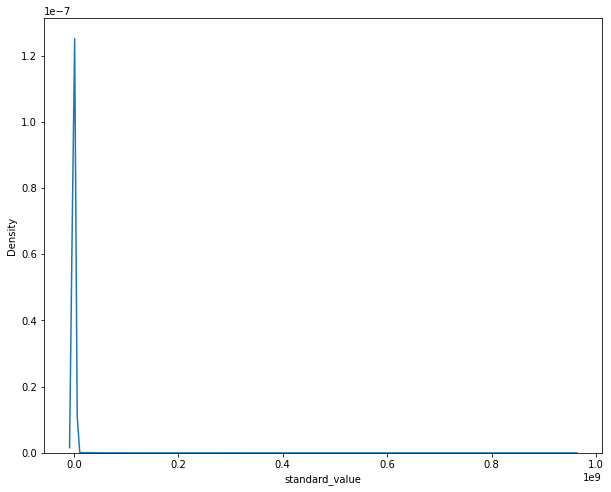

In [191]:
fig = plt.figure(figsize=(10,8))
sns.kdeplot(chembl_dataset["standard_value"])
plt.show()

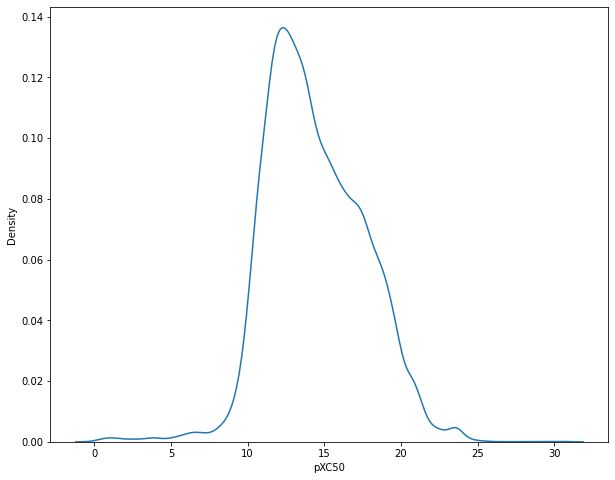

In [192]:
# Convert from standard values to pXC50
chembl_dataset["pXC50"] = -np.log(chembl_dataset["standard_value"]*(10**-9))

fig = plt.figure(figsize=(10,8))
sns.kdeplot(chembl_dataset["pXC50"])
plt.show()

In [193]:
# CLEANING PROCEDURE AS OUTLINED IN https://iwatobipen.wordpress.com/2022/04/08/make-curated-kinase-inhibitor-dataset-from-chembl30-memo-chemoinformatcs/
def clean_data(chembl_dataset, activity_label):
    # 1. Remove extremes
    if activity_label == "pXC50":
        no_extreme = chembl_dataset.query("1 <= `pXC50` <= 15")
        print("Compounds without extremes:", no_extreme.shape[0])
    else:
        no_extreme = chembl_dataset

    # 2. Remove values in the same publication against the same target, keep the first (max) occurence
    max_activity_same_publication = no_extreme.sort_values(activity_label, ascending=False).drop_duplicates(["chembl_id", "moldict_id", "docs_id"])
    print("Compounds with multiple values in the same publication:", max_activity_same_publication.shape[0])

    # 3. Remove measurements that cite original publications and remove rounding errors
    no_exact_duplicates = max_activity_same_publication.drop_duplicates(["chembl_id", "moldict_id", activity_label])
    no_rounded_duplicates = (
        no_exact_duplicates
            .assign(activities_standard_value_rounded=lambda x: x[activity_label].round(2))
            .drop_duplicates(["chembl_id", "moldict_id", "activities_standard_value_rounded"])
            .drop(columns=["activities_standard_value_rounded"])
    )
    print("Compounds with citing of original publication and rounding errors:", no_rounded_duplicates.shape[0])
    return no_rounded_duplicates


In [194]:
no_rounded_duplicates_potency = clean_data(chembl_dataset=chembl_dataset, activity_label="pXC50")

Compounds without extremes: 15546
Compounds with multiple values in the same publication: 14723
Compounds with citing of original publication and rounding errors: 14099


In [195]:
no_rounded_duplicates_cad = clean_data(chembl_dataset=CAD_dataset, activity_label="standard_value")

Compounds with multiple values in the same publication: 40
Compounds with citing of original publication and rounding errors: 40


In [196]:
no_rounded_duplicates_clnd = clean_data(chembl_dataset=CLND_dataset, activity_label="standard_value")

Compounds with multiple values in the same publication: 369
Compounds with citing of original publication and rounding errors: 369


In [197]:
no_rounded_duplicates_clogd = clean_data(chembl_dataset=clogd_dataset, activity_label="standard_value")

Compounds with multiple values in the same publication: 973
Compounds with citing of original publication and rounding errors: 970


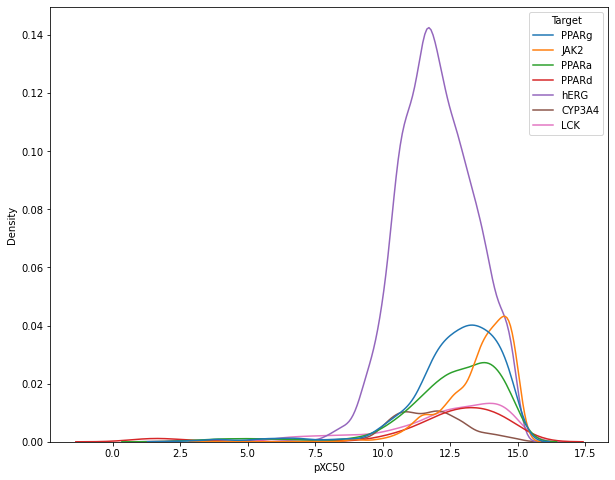

In [198]:
fig = plt.figure(figsize=(10,8))
sns.kdeplot(data=no_rounded_duplicates_potency, x="pXC50", hue="Target")
plt.show()


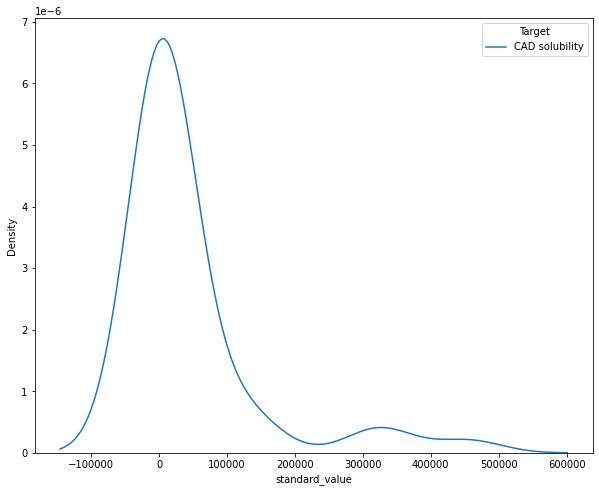

In [199]:
fig = plt.figure(figsize=(10,8))
sns.kdeplot(data=no_rounded_duplicates_cad, x="standard_value", hue="Target")
plt.show()

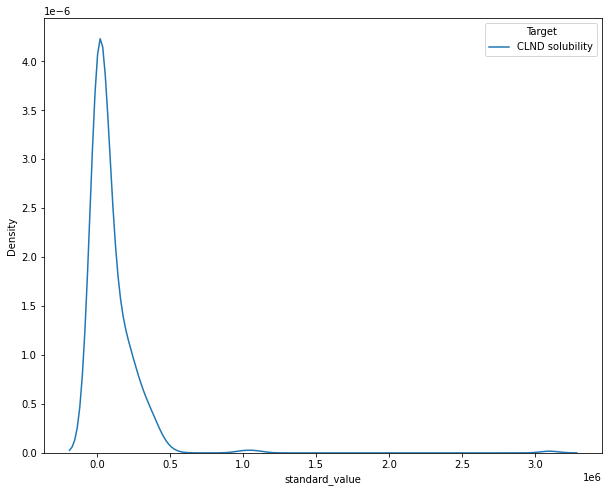

In [201]:
fig = plt.figure(figsize=(10,8))
sns.kdeplot(data=no_rounded_duplicates_clnd, x="standard_value", hue="Target")
plt.show()

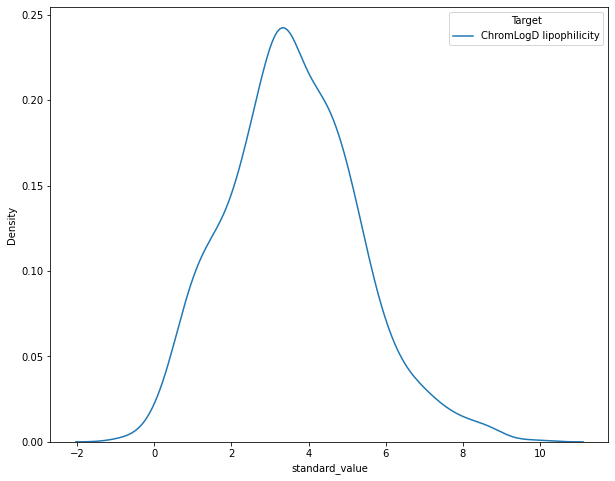

In [202]:
fig = plt.figure(figsize=(10,8))
sns.kdeplot(data=no_rounded_duplicates_clogd, x="standard_value", hue="Target")
plt.show()

In [203]:
final_chembl_dataset = pd.concat([no_rounded_duplicates_potency, no_rounded_duplicates_cad, no_rounded_duplicates_clnd, no_rounded_duplicates_clogd])

In [204]:
# Finally, combine any compounds that have standard deviations in (-0.5, 0.5) by taking the mean and clean SMILES if they contain fragments
def group_dfs_get_means_clean_smi(endpoint_col, df, target):
    df_grouped = df.groupby(['canonical_smiles'], as_index=False).agg({endpoint_col:['mean','std'],'molregno':'first', 'canonical_smiles':'first'})
    df_grouped.columns = [endpoint_col+'_mean', endpoint_col+'_stddev','molregno','canonical_smiles']
    df_grouped = df_grouped.reindex(columns=sorted(df_grouped.columns))

    # Remove any large stddevs
    df_grouped_clean = df_grouped[((df_grouped[endpoint_col+'_stddev'] <= 0.5) & (df_grouped[endpoint_col+'_stddev'] >= -0.5)) | (df_grouped[endpoint_col+'_stddev'].isna())]
    df_grouped_clean["Target"] = target
    df_grouped_clean["Endpoint_mean"] = df_grouped_clean[endpoint_col+'_mean']
    
    clean_smi = []
    
    for idx, row in df_grouped_clean.iterrows():
        if "." in row["canonical_smiles"]:
            clean_smi.append(Chem.MolToSmiles(FragmentParent(Chem.MolFromSmiles(row["canonical_smiles"]))))
        else:
            clean_smi.append(row["canonical_smiles"])
            
    df_grouped_clean["SMILES_cleaned"] = clean_smi
    
    return df_grouped_clean


In [205]:
chembl_name_to_gene.values()

dict_values(['JAK2', 'LCK', 'PPARa', 'PPARd', 'PPARg', 'hERG', 'CYP3A4'])

In [ ]:
final_dfs = []

for target in final_chembl_dataset['Target'].unique():
    df_target = final_chembl_dataset[final_chembl_dataset['Target'] == target]
    
    if target in chembl_name_to_gene.values():
        df_target_grouped = group_dfs_get_means_clean_smi("pXC50", df_target, target)
    else:
        df_target_grouped = group_dfs_get_means_clean_smi("standard_value", df_target, target)
    
    final_dfs.append(df_target_grouped)
    
final_chembl_dataset_unique_cmpds = pd.concat([i for i in final_dfs])

In [207]:
print("Compounds per target before duplicate removal")
final_chembl_dataset[['molregno', 'Target']].groupby('Target').count().reset_index()


Compounds per target before duplicate removal


,Target,molregno
0,CAD solubility,40
1,CLND solubility,369
2,CYP3A4,522
3,ChromLogD lipophilicity,970
4,JAK2,1433
5,LCK,847
6,PPARa,1513
7,PPARd,692
8,PPARg,2073
9,hERG,7019


In [208]:
print("Compounds per target after duplicate removal")
final_chembl_dataset_unique_cmpds[['molregno', 'Target']].groupby('Target').count().reset_index()


Compounds per target after duplicate removal


,Target,molregno
0,CAD solubility,40
1,CLND solubility,369
2,CYP3A4,519
3,ChromLogD lipophilicity,970
4,JAK2,1368
5,LCK,808
6,PPARa,1314
7,PPARd,656
8,PPARg,1881
9,hERG,6791


In [209]:
final_chembl_dataset_unique_cmpds["Target"].unique()

array(['PPARg', 'JAK2', 'PPARa', 'PPARd', 'hERG', 'CYP3A4', 'LCK',
       'CAD solubility', 'CLND solubility', 'ChromLogD lipophilicity'],
      dtype=object)

In [210]:
len(final_chembl_dataset_unique_cmpds["canonical_smiles"].unique())

13358

In [211]:
final_chembl_dataset_unique_cmpds.to_csv("chembl_qsar_data.tsv", sep="\t", index=False)